# Data Analysis for FD003

In [48]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.nonparametric.smoothers_lowess import lowess
import pyclustering
import tslearn
import pymannkendall as mk

## Data Preprocessing

In [49]:
train_data_df = pd.read_csv('../../TED/CMAPSSData/train_FD003.txt', sep=' ', header = None)
test_data_df = pd.read_csv('../../TED/CMAPSSData/test_FD003.txt', sep=' ', header = None)
test_labels_at_break_df = pd.read_csv('../../TED/CMAPSSData/RUL_FD003.txt', sep=' ', header = None)

train_data_df.drop(train_data_df.columns[[-1, -2]], axis=1, inplace=True)
test_data_df.drop(test_data_df.columns[[-1, -2]], axis=1, inplace=True)
test_labels_at_break_df.drop(test_labels_at_break_df.columns[[-1]], axis=1, inplace=True)

### Extracting labels and organising the data

In [50]:
column_names = ['ID', 'Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1', 'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8', 'SensorMeasure9', 'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15', 'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18', 'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21']

train_data_df.columns = column_names
max_cycles_train_df = train_data_df.groupby(['ID'], sort=False)['Cycle'].max().reset_index().rename(columns={'Cycle':'MaxCycleID'})

train_data_df = pd.merge(train_data_df, max_cycles_train_df, how='inner', on='ID')
train_data_df['RUL'] = train_data_df['MaxCycleID'] - train_data_df['Cycle']
train_data_df.drop(columns=['MaxCycleID'], inplace=True)

test_data_df.columns = column_names
max_cycles_test_df = test_data_df.groupby(['ID'], sort=False)['Cycle'].max().reset_index().rename(columns={'Cycle':'MaxCycleID'})

test_labels_at_break_df.columns = ['RUL']
test_labels_at_break_df['ID'] = max_cycles_test_df['ID']
test_labels_at_break_df['RUL'] = test_labels_at_break_df['RUL'] + max_cycles_test_df['MaxCycleID']

test_data_df = pd.merge(test_data_df, test_labels_at_break_df, how='inner', on='ID')
test_data_df['RUL'] = test_data_df['RUL'] - test_data_df['Cycle']

In [51]:
train_labels_df = train_data_df['RUL']
test_labels_df = test_data_df['RUL']
train_labels_at_break_df = train_data_df.groupby('ID').last().reset_index()['RUL']

### Divide by engine

In [52]:
train_groupby = train_data_df.groupby(['ID'], sort=False)
test_groupby = test_data_df.groupby(['ID'], sort=False)

### Graphs: Data before analysed

In [53]:
sensor_names = []
for i in range(3):
    sensor_names.append('OpSet' + str(i+1))
for i in range(21):
    sensor_names.append('SensorMeasure' + str(i+1))

In [54]:
def divide_by_engine(df_groupby):

    groupby_arr = []
    for i in range(len(df_groupby)):
        groupby_arr.append(df_groupby.get_group(i+1))

    for i in range(len(df_groupby)):
        groupby_arr[i] = groupby_arr[i].to_numpy()

    return groupby_arr

In [55]:
def plot_by_engine(train_gb, rows, names, filename):

    train_groupby_arr = divide_by_engine(train_gb)

    fig, axs = plt.subplots(rows, 4)
    flat_axs = axs.flatten()
    for sensor in range(len(names)):
        flat_axs[sensor].set_title(names[sensor])
        for engine in range(len(train_groupby_arr)):
            flat_axs[sensor].plot(train_groupby_arr[engine][:, 1], train_groupby_arr[engine][:, sensor + 2])

    plt.setp(axs[-1, :], xlabel='Cycles')
    plt.setp(axs[:, 0], ylabel='Sensor readings')
    fig.set_size_inches(20, 30) 
    plt.savefig(filename)
    plt.show()

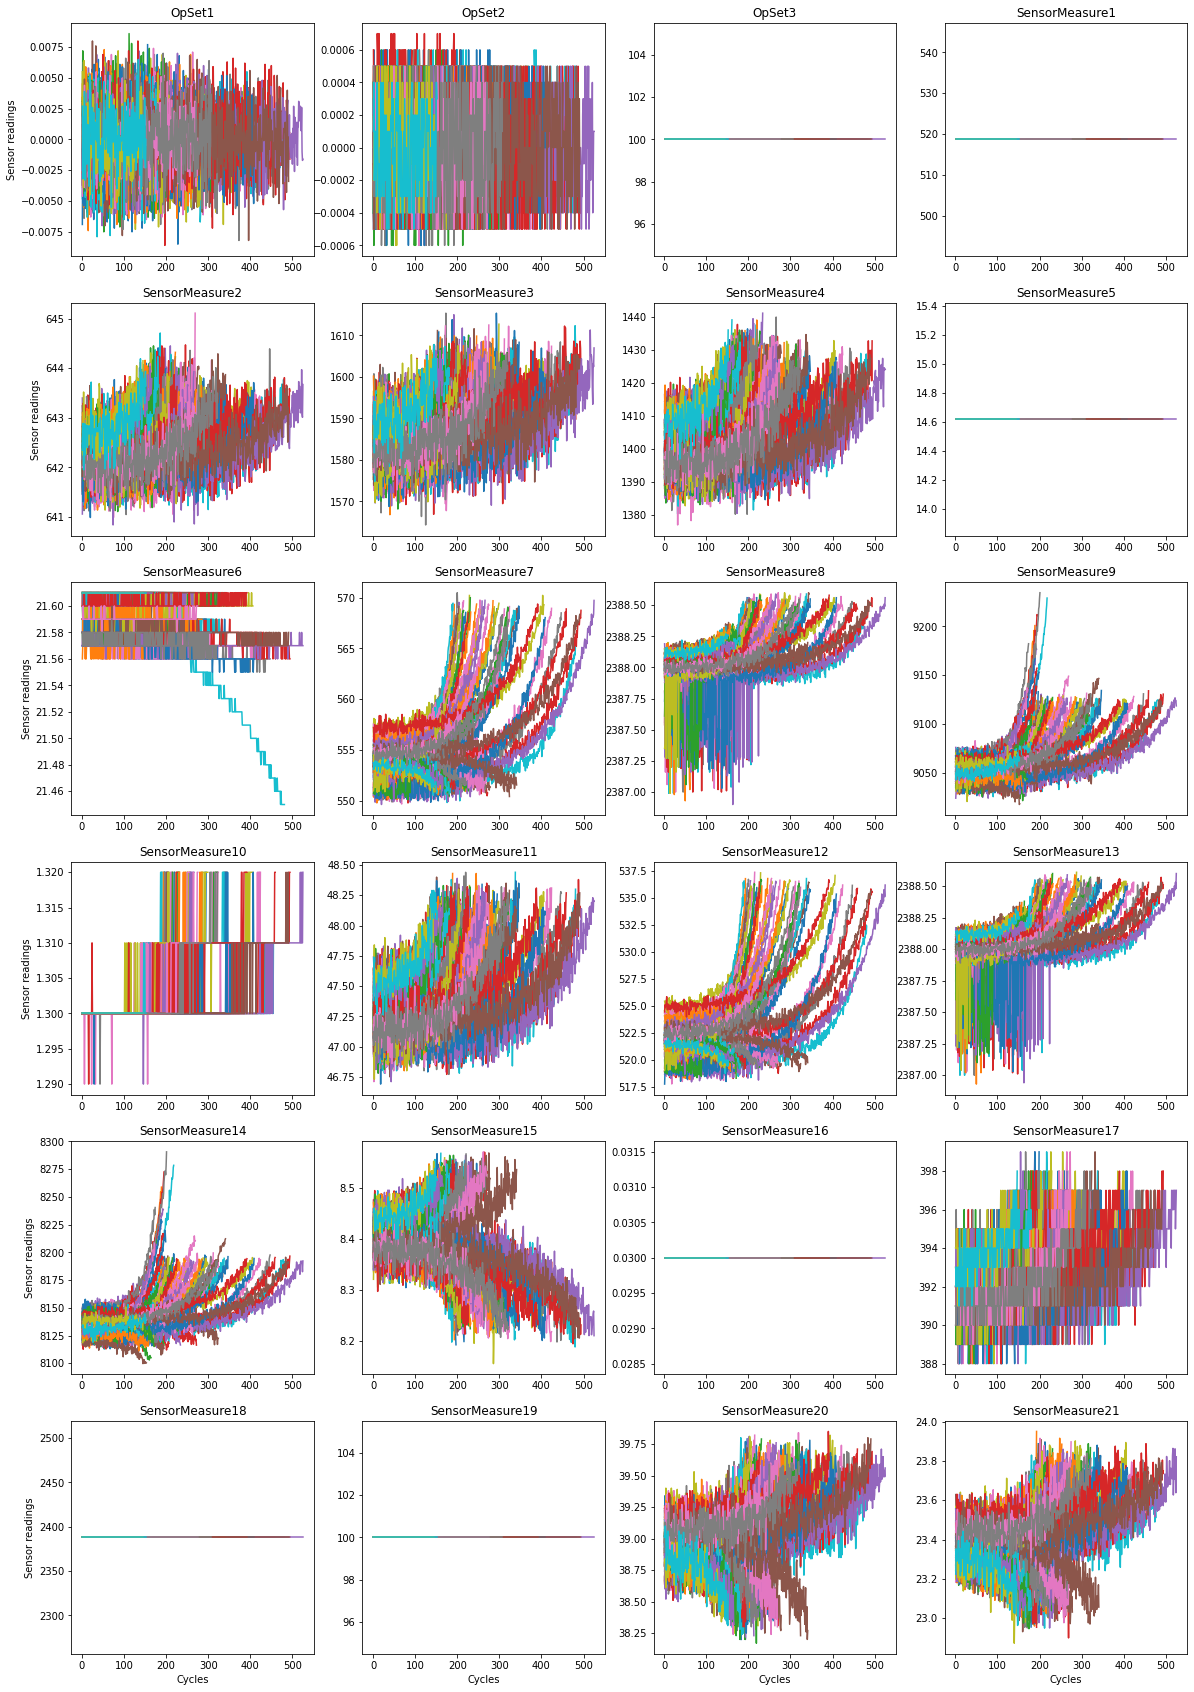

In [56]:
plot_by_engine(train_groupby, 6, sensor_names, 'fd003-sensors_unprocessed.jpg')

From the graph, we can see which sensors will have a greater impact on the performance of the regressor, and which are irrelevant for this task. I decided to take Sensors: 1, 5, 6, 10, 16, 18, 19

### Feature selection

In [57]:
sensors_used = []
sensors_used.append('ID')
sensors_used.append('Cycle')
for i in range(1, 22):
    sensors_used.append("SensorMeasure" + str(i))

<function matplotlib.pyplot.show(close=None, block=None)>

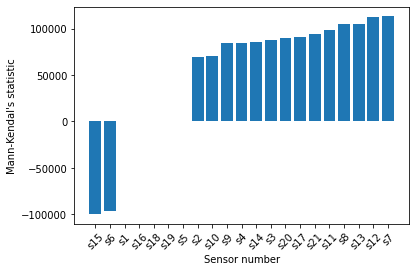

In [58]:
# PyMannKendall test: Code by Zhan Liang, Chan - https://github.com/cchanzl/survival-analysis-nasa/blob/main/nasa_eda.ipynb
avg_cycle = []
for i in range(1, 101):
    df_engine = train_data_df[train_data_df['ID'] == i]
    max_cycle = df_engine.loc[df_engine['Cycle'].idxmax()]
    avg_cycle.append(max_cycle["Cycle"].astype(int))

no_columns = 21
up_sensor_values = np.empty([max(avg_cycle), no_columns]) # 26 sensors with a max cycle of 362
lo_sensor_values = np.empty([max(avg_cycle), no_columns]) # 26 sensors with a max cycle of 362
for col in range(0, no_columns):
    sensor = 'SensorMeasure'
    sensor = sensor + str(col+1)
    for row in range(0, max(avg_cycle)):
        df_train_sens = train_data_df[train_data_df['Cycle'] == row+1]
        
        # find max and min value of a sensor for each cycle
        max_value = df_train_sens.loc[df_train_sens[sensor].idxmax()]
        min_value = df_train_sens.loc[df_train_sens[sensor].idxmin()]
        
        # store max and min value
        up_sensor_values[row, col] = max_value[sensor]
        lo_sensor_values[row, col] = min_value[sensor]
mean_trend = (up_sensor_values + lo_sensor_values)/2

mono = []
def MannKendall(sensor_number, mean_trend, p_value=False):
    sensor_number -= 1
    trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test([row[sensor_number] for row in mean_trend], alpha=0.05)
    if p_value:
        print("{:e}".format(var_s))
    return s

# make x label for graphing
sensor_header = []
for i in range(0, 21):
    name = "s"
    name = name + str(i+1)
    sensor_header.append(name)

# retrieve y axis reading
for i in range(1, no_columns+1):
    mono.append(MannKendall(i, mean_trend))

y,x = zip(*sorted(zip(mono,sensor_header)))
plt.bar(x, y)
plt.xlabel("Sensor number")
plt.ylabel("Mann-Kendall's statistic")
plt.xticks(rotation=45)
plt.show

For this dataset, Sensors 1, 5, 16, 18, 19 will be discarded. However, I will also discard 6 and 10 (like for FD002) as the range of values of Sensor 10 is very small and the curves for Sensor 6 do not seem predictable at all. I will also give consistency between datasets. 

In [59]:
sensors_used = []
sensors_used.append('ID')
sensors_used.append('Cycle')
for i in range(1, 22):
    if i not in [1, 5, 6, 10, 16, 18, 19]:
        sensors_used.append("SensorMeasure" + str(i))

In [60]:
train_data_df = train_data_df[sensors_used]
test_data_df = test_data_df[sensors_used]

### Principal Component Analysis

In [61]:
print(train_data_df.shape)
ms_used = sensors_used[2:]
print(len(ms_used))

(24720, 16)
14


In [62]:
sc = StandardScaler()
scaled_values = sc.fit_transform(train_data_df.values[:, 2:])

pca = PCA(n_components = 0.95)
pca_values = pca.fit_transform(scaled_values)

Number of components: 7


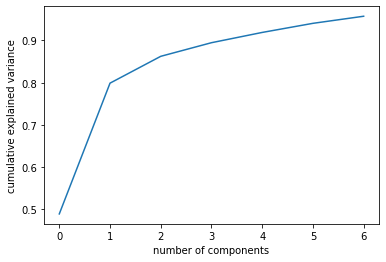

In [63]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
print("Number of components: " + str(pca.n_components_))

In [64]:
pd.DataFrame(pca.components_, columns = ms_used)

SensorMeasure2  SensorMeasure3  SensorMeasure4  SensorMeasure7  \
0        0.228316        0.272060        0.257817        0.294838   
1        0.286240        0.214591        0.289275       -0.288180   
2       -0.051119       -0.052125       -0.039928       -0.080467   
3        0.443848        0.061169        0.276979        0.148446   
4       -0.366226        0.889242       -0.017123       -0.002336   
5       -0.627398       -0.120008        0.172817        0.030527   
6        0.362531        0.254606       -0.594530       -0.064194   

   SensorMeasure8  SensorMeasure9  SensorMeasure11  SensorMeasure12  \
0        0.332417        0.312243         0.282789         0.300023   
1        0.049730       -0.001513         0.261729        -0.280481   
2       -0.327505        0.580960        -0.076852        -0.078287   
3       -0.489721       -0.151786         0.270512         0.153650   
4       -0.103273       -0.044724        -0.015602        -0.001322   
5       -0.143757       -0.052397         0.149690         0.034417   
6       -0.052965       -0.035015        -0.325183        -0.066125   

   SensorMeasure13  SensorMeasure14  SensorMeasure15  SensorMeasure17  \
0         0.332377         0.294313        -0.153549         0.280079   
1         0.049233        -0.053955         0.408270         0.225208   
2        -0.328254         0.635088         0.055299        -0.044479   
3        -0.490088        -0.188791        -0.188821         0.031509   
4        -0.106087        -0.037320        -0.032295        -0.219229   
5        -0.139102        -0.069662        -0.032701         0.699122   
6        -0.053492        -0.007531        -0.020805         0.565610   

   SensorMeasure20  SensorMeasure21  
0         0.146147         0.148327  
1        -0.408111        -0.407861  
2        -0.086703        -0.078419  
3         0.115869         0.122283  
4         0.011222         0.006344  
5         0.007031        -0.008708  
6         0.079881         0.048641

In [65]:
n_pcs = pca.n_components_
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = ms_used
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

print(most_important_names)

['SensorMeasure8', 'SensorMeasure15', 'SensorMeasure14', 'SensorMeasure13', 'SensorMeasure3', 'SensorMeasure17', 'SensorMeasure4']


In [66]:
fig = px.scatter_3d(pca_values, x=0, y=1, z=2, color=train_data_df['ID'])
fig.show()
fig.write_html("fd003-PCA-3d_plot.html")

In [67]:
train_data_df.to_csv('./fd003-raw_train.csv', sep=' ', columns=train_data_df.columns, index=False)
test_data_df[train_data_df.columns].to_csv('./fd003-raw_test.csv', sep=' ', columns=train_data_df.columns, index=False)

In [68]:
train_labels_df.to_csv('./fd003-training_labels.csv', sep=' ', columns=['RUL'], index=False)
test_labels_df.to_csv('./fd003-testing_labels.csv', sep=' ', columns=['RUL'], index=False)
train_labels_at_break_df.to_csv('./fd003-testing_labels_at_break.csv', sep=' ', columns=['RUL'], index=False)

### Scaling and Normalising Data

In [69]:
train_data_df

ID  Cycle  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0        1      1          642.36         1583.23         1396.84   
1        1      2          642.50         1584.69         1396.89   
2        1      3          642.18         1582.35         1405.61   
3        1      4          642.92         1585.61         1392.27   
4        1      5          641.68         1588.63         1397.65   
...    ...    ...             ...             ...             ...   
24715  100    148          643.78         1596.01         1424.11   
24716  100    149          643.29         1596.38         1429.14   
24717  100    150          643.84         1604.53         1431.41   
24718  100    151          643.94         1597.56         1426.57   
24719  100    152          643.64         1599.04         1436.06   

       SensorMeasure7  SensorMeasure8  SensorMeasure9  SensorMeasure11  \
0              553.97         2387.96         9062.17            47.30   
1              554.55         2388.00         9061.78            47.23   
2              554.43         2388.03         9070.23            47.22   
3              555.21         2388.00         9064.57            47.24   
4              554.74         2388.04         9076.14            47.15   
...               ...             ...             ...              ...   
24715          551.86         2388.25         9070.82            48.27   
24716          551.86         2388.23         9064.60            48.13   
24717          551.30         2388.25         9063.45            48.18   
24718          550.69         2388.26         9062.22            48.05   
24719          550.96         2388.26         9066.52            48.12   

       SensorMeasure12  SensorMeasure13  SensorMeasure14  SensorMeasure15  \
0               522.31          2388.01          8145.32           8.4246   
1               522.42          2388.03          8152.85           8.4403   
2               522.03          2388.00          8150.17           8.3901   
3               522.49          2388.08          8146.56           8.3878   
4               522.58          2388.03          8147.80           8.3869   
...                ...              ...              ...              ...   
24715           519.66          2388.30          8138.08           8.5036   
24716           519.91          2388.28          8144.36           8.5174   
24717           519.44          2388.24          8135.95           8.5223   
24718           520.01          2388.26          8141.24           8.5148   
24719           519.48          2388.24          8136.98           8.5150   

       SensorMeasure17  SensorMeasure20  SensorMeasure21  
0                  391            39.11          23.3537  
1                  392            38.99          23.4491  
2                  391            38.85          23.3669  
3                  392            38.96          23.2951  
4                  392            39.14          23.4583  
...                ...              ...              ...  
24715              394            38.44          22.9631  
24716              395            38.50          22.9746  
24717              396            38.39          23.0682  
24718              395            38.31          23.0753  
24719              396            38.56          23.0847  

[24720 rows x 16 columns]

In [70]:
sc = StandardScaler()
for sensor in ms_used:
    train_data_df.loc[:,sensor] = sc.fit_transform(train_data_df[sensor].values.reshape(-1, 1))
    test_data_df.loc[:,sensor] = sc.fit_transform(test_data_df[sensor].values.reshape(-1, 1))

/opt/homebrew/lib/python3.9/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/homebrew/lib/python3.9/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/homebrew/lib/python3.9/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [71]:
train_data_df

ID  Cycle  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0        1      1       -0.187102       -0.712038       -0.780848   
1        1      2        0.080574       -0.497656       -0.775732   
2        1      3       -0.531256       -0.841254        0.116524   
3        1      4        0.883602       -0.362566       -1.248464   
4        1      5       -1.487242        0.080881       -0.697966   
...    ...    ...             ...             ...             ...   
24715  100    148        2.527897        1.164537        2.009498   
24716  100    149        1.591031        1.218867        2.524183   
24717  100    150        2.642615        2.415587        2.756456   
24718  100    151        2.833812        1.392134        2.261213   
24719  100    152        2.260221        1.609453        3.232257   

       SensorMeasure7  SensorMeasure8  SensorMeasure9  SensorMeasure11  \
0           -0.341494       -0.704785       -0.097138        -0.385602   
1           -0.172755       -0.452071       -0.116658        -0.618882   
2           -0.207667       -0.262536        0.306267        -0.652208   
3            0.019257       -0.452071        0.022983        -0.585556   
4           -0.117479       -0.199357        0.602065        -0.885488   
...               ...             ...             ...              ...   
24715       -0.955353        1.127391        0.335797         2.846998   
24716       -0.955353        1.001034        0.024484         2.380437   
24717       -1.118272        1.127391       -0.033074         2.547066   
24718       -1.295739        1.190569       -0.094636         2.113831   
24719       -1.217188        1.190569        0.120581         2.347112   

       SensorMeasure12  SensorMeasure13  SensorMeasure14  SensorMeasure15  \
0            -0.227593        -0.389857         0.067687         0.469741   
1            -0.193802        -0.263369         0.523946         0.729201   
2            -0.313608        -0.453101         0.361559        -0.100409   
3            -0.172298         0.052852         0.142821        -0.138419   
4            -0.144650        -0.263369         0.217955        -0.153292   
...                ...              ...              ...              ...   
24715        -1.041663         1.444222        -0.371001         1.775302   
24716        -0.964864         1.317734         0.009518         2.003362   
24717        -1.109246         1.064758        -0.500062         2.084340   
24718        -0.934145         1.191246        -0.179530         1.960394   
24719        -1.096959         1.064758        -0.437652         1.963699   

       SensorMeasure17  SensorMeasure20  SensorMeasure21  
0            -0.889364         0.488019        -0.263512  
1            -0.321641         0.005819         0.375767  
2            -0.889364        -0.556747        -0.175058  
3            -0.321641        -0.114730        -0.656192  
4            -0.321641         0.608569         0.437416  
...                ...              ...              ...  
24715         0.813805        -2.204262        -2.880934  
24716         1.381528        -1.963162        -2.803872  
24717         1.949251        -2.405178        -2.176656  
24718         1.381528        -2.726644        -2.129079  
24719         1.949251        -1.722062        -2.066089  

[24720 rows x 16 columns]

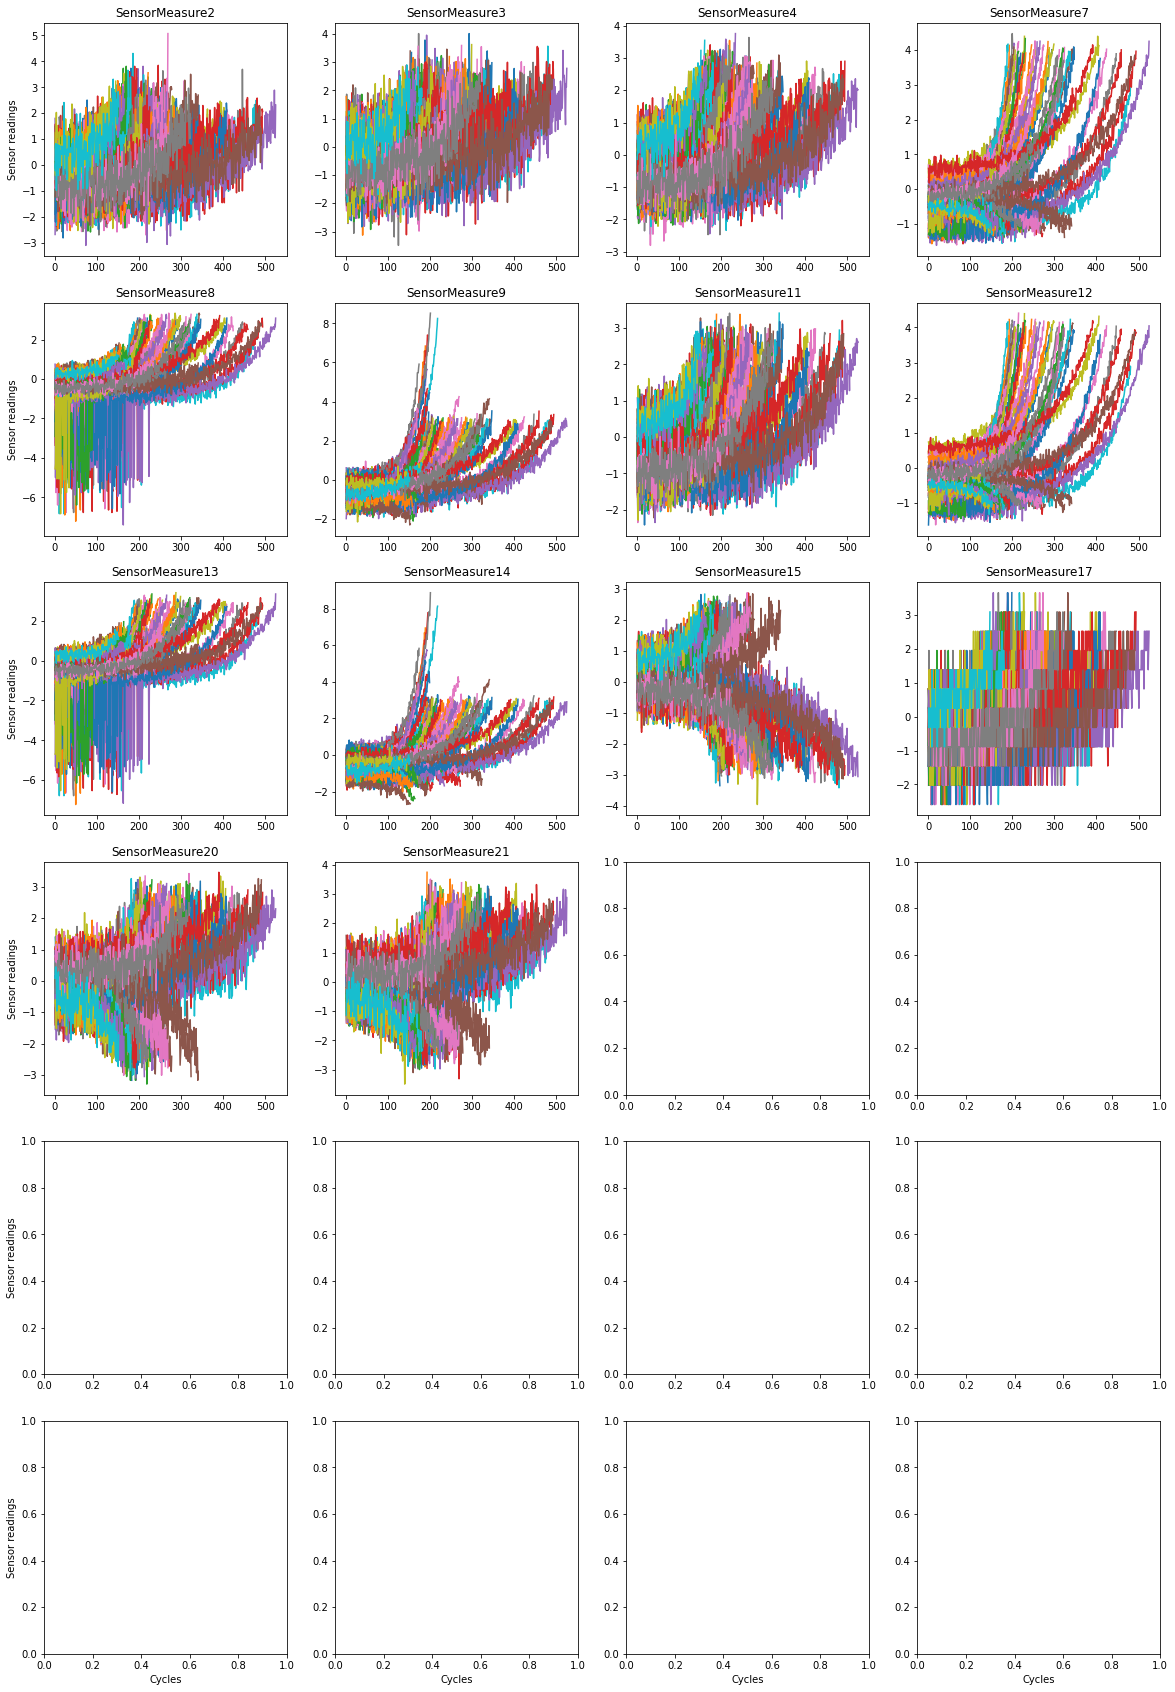

In [72]:
train_groupby = train_data_df.groupby(['ID'], sort=False)
plot_by_engine(train_groupby, 6, ms_used, 'fd003-sensors_scaled.jpg')

In [73]:
train_data_df.to_csv('./fd003-scaled_train.csv', sep=' ', columns=train_data_df.columns, index=False)
test_data_df[train_data_df.columns].to_csv('./fd003-scaled_test.csv', sep=' ', columns=train_data_df.columns, index=False)

### Smoothing curves

In [74]:
train_groupby = train_groupby[['ID', 'Cycle'] + ms_used]
test_groupby = test_groupby[['ID', 'Cycle'] + ms_used]
train_groupby.get_group(1)

ID  Cycle  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0     1      1       -0.187102       -0.712038       -0.780848   
1     1      2        0.080574       -0.497656       -0.775732   
2     1      3       -0.531256       -0.841254        0.116524   
3     1      4        0.883602       -0.362566       -1.248464   
4     1      5       -1.487242        0.080881       -0.697966   
..   ..    ...             ...             ...             ...   
254   1    255        1.801348        1.731327        2.397302   
255   1    256        2.642615        1.649099        1.970616   
256   1    257        2.030784        1.951583        2.126146   
257   1    258        2.298460        2.748907        2.750316   
258   1    259        2.833812        1.682871        3.055239   

     SensorMeasure7  SensorMeasure8  SensorMeasure9  SensorMeasure11  \
0         -0.341494       -0.704785       -0.097138        -0.385602   
1         -0.172755       -0.452071       -0.116658        -0.618882   
2         -0.207667       -0.262536        0.306267        -0.652208   
3          0.019257       -0.452071        0.022983        -0.585556   
4         -0.117479       -0.199357        0.602065        -0.885488   
..              ...             ...             ...              ...   
254       -0.888439        1.316926        0.675138         2.747021   
255       -1.013538        0.748320        0.326788         2.113831   
256       -1.077542        1.316926        0.713177         2.480415   
257       -0.952443        1.316926        1.040005         2.313786   
258       -1.030994        1.127391        0.610073         3.080278   

     SensorMeasure12  SensorMeasure13  SensorMeasure14  SensorMeasure15  \
0          -0.227593        -0.389857         0.067687         0.469741   
1          -0.193802        -0.263369         0.523946         0.729201   
2          -0.313608        -0.453101         0.361559        -0.100409   
3          -0.172298         0.052852         0.142821        -0.138419   
4          -0.144650        -0.263369         0.217955        -0.153292   
..               ...              ...              ...              ...   
254        -0.845058         0.938269        -0.055921         2.011625   
255        -0.971008         0.938269         0.420333         1.811659   
256        -1.026304         1.191246         0.312479         2.224812   
257        -1.023232         0.875025         0.407003         1.628220   
258        -1.109246         1.001514         0.299755         2.233075   

     SensorMeasure17  SensorMeasure20  SensorMeasure21  
0          -0.889364         0.488019        -0.263512  
1          -0.321641         0.005819         0.375767  
2          -0.889364        -0.556747        -0.175058  
3          -0.321641        -0.114730        -0.656192  
4          -0.321641         0.608569         0.437416  
..               ...              ...              ...  
254         0.813805        -2.405178        -2.153872  
255         2.516973        -2.123895        -2.306656  
256         3.084696        -2.525728        -1.924697  
257         1.949251        -2.003345        -2.192738  
258         3.084696        -2.565911        -2.159903  

[259 rows x 16 columns]

In [75]:
smoothing_columns = ['ID', 'Cycle'] + ms_used
train_groupby_arr = []
for i in range(len(train_groupby)):
    df = train_groupby.get_group(i+1).copy()
    lowess_df = df.copy()
    for sensor in range(2, len(smoothing_columns)):
        sn = smoothing_columns[sensor]
        lowess_df[sn] = pd.DataFrame(lowess(df[sn], np.arange(len(df[sn])), frac=0.35)[:, 1], index=df.index, columns=[sn])
    train_groupby_arr.append(lowess_df)

tr_joined_lowess_df = train_groupby_arr[0]
for i in range(1, len(train_groupby_arr)):
    tr_joined_lowess_df = pd.concat([tr_joined_lowess_df, train_groupby_arr[i]])

test_groupby_arr = []
for i in range(len(test_groupby)):
    df = test_groupby.get_group(i+1).copy()
    lowess_df = df.copy()
    for sensor in range(2, len(smoothing_columns)):
        sn = smoothing_columns[sensor]
        lowess_df[sn] = pd.DataFrame(lowess(df[sn], np.arange(len(df[sn])), frac=0.35)[:, 1], index=df.index, columns=[sn])
    test_groupby_arr.append(lowess_df)

test_joined_lowess_df = test_groupby_arr[0]
for i in range(1, len(test_groupby_arr)):
    test_joined_lowess_df = pd.concat([test_joined_lowess_df, test_groupby_arr[i]])

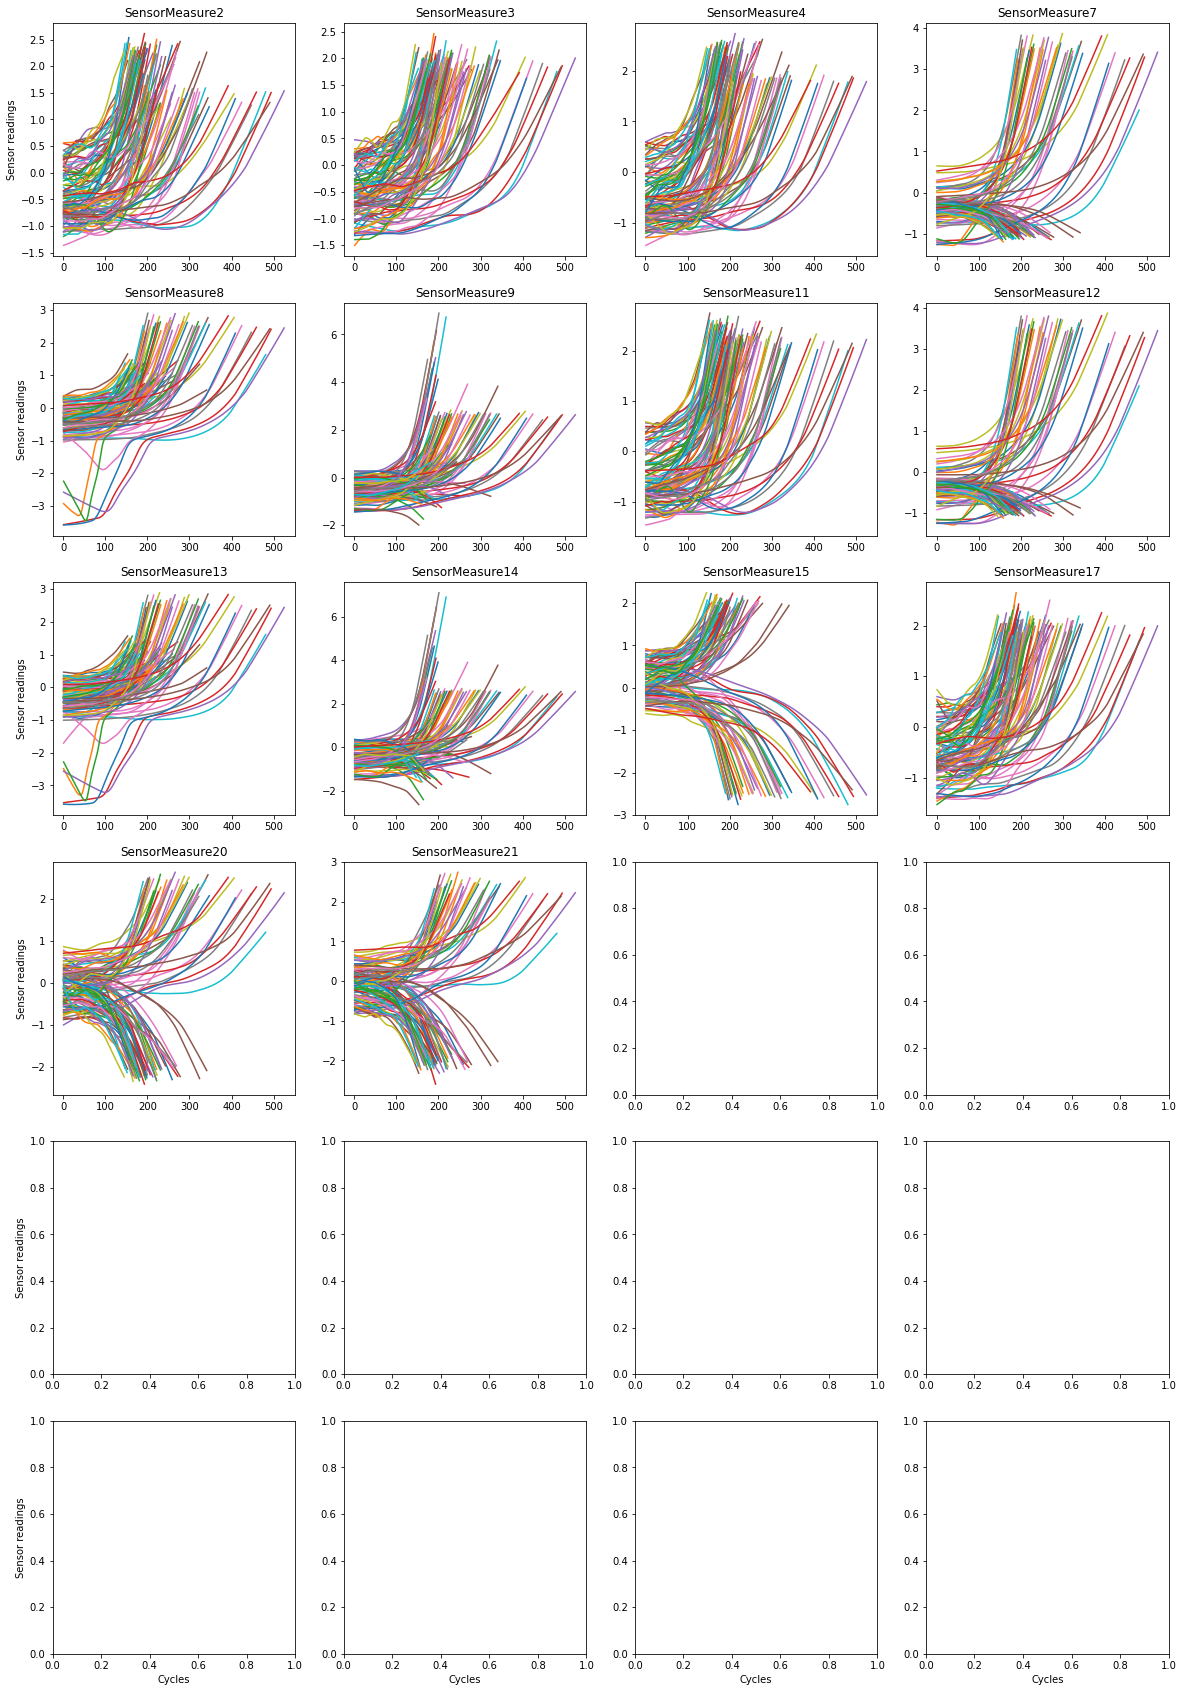

In [76]:
tr_joined_lowess_groupby = tr_joined_lowess_df.groupby(['ID'], sort = False)
plot_by_engine(tr_joined_lowess_groupby, 6, ms_used, 'fd003-sensors_smoothed.jpg')

In [77]:
tr_joined_lowess_df.to_csv('./fd003-smoothed_train.csv', sep=' ', columns=tr_joined_lowess_df.columns, index=False)
test_joined_lowess_df.to_csv('./fd003-smoothed_test.csv', sep=' ', columns=test_joined_lowess_df.columns, index=False)

## Fault modes: Clustering engines